In [1]:
import numpy as np
from scipy.special import softmax
import math
from numpy.random import default_rng
import matplotlib 
import matplotlib.pyplot as plt
time = 5
states = [0, 1]
actions = [0, 1, 2, 3]
# transition = np.array([[0.5,0.6,0.7,0.8],
#         [0.7, 0.8, 0.9, 1]])
transition = np.array([[0.8,0.7,0.6,0.5],
        [1, 0.9, 0.8, 0.7]])
theta_0 = np.ones(4)
rewards = np.array([[1,2,3,4], [5,6,7,8]])
#rewards = np.array([[0.5,1,1.5,2],
 #                 [2.5,3,3.5,4]])
M = 2 
sigma_0 = 1
eps_0 = 1
r = 2
rho = (1/2) * (1+r)
L = 5
gamma_0 = (1+r)/L
rng = default_rng()

In [4]:
rewards[1,:]

array([5, 6, 7, 8])

In [3]:
def gamma_1(theta):
    t = np.arange(time)
    f = t*((4*np.max(softmax(theta)))**t)
    return (4*np.max(softmax(theta)))**(time) * np.sum(f) * (1+M)**(1/2) * (np.max(np.abs(rewards)))

#brauchen wir im Moment nicht

In [4]:
def grad_soft(theta):
    return np.eye(len(theta),len(theta))- np.matmul(softmax(theta).reshape(len(theta),1), np.ones((1,len(theta))))

grad_soft(theta_0)[[0,1,0,0]]

array([[ 0.75, -0.25, -0.25, -0.25],
       [-0.25,  0.75, -0.25, -0.25],
       [ 0.75, -0.25, -0.25, -0.25],
       [ 0.75, -0.25, -0.25, -0.25]])

In [5]:
def sample(theta, t, state, action):
    if action == None:
        trajectory = [state]
        for n in range((time-t)):
            action = np.random.choice(actions, p=softmax(theta), size=1)[0]
            trajectory.append(action)
            state = rng.binomial(1, p=(1-transition[state, action]), size=1)[0]
            trajectory.append(state)
    else:
        trajectory = [state, action]
        for n in range((time-t)):
            state = rng.binomial(1, p=(1-transition[state, action]), size=1)[0]
            trajectory.append(state)
            action = np.random.choice(actions, p=softmax(theta), size=1)[0]
            trajectory.append(action)

    return trajectory

In [9]:
#Das ist der Code, der zur Theorie passt, aber viel zu langsam ist
theta = theta_0
print(theta)
for n in range(1,100):
    print(n)
    eps_n = eps_0 * 1/(n**rho)
    sigma_n = 1/(n**r) * sigma_0
    gamma_n = gamma_0 * 1/n
    m_n = max(math.ceil((np.log(1/eps_n)) / np.log(M)), 1)
    print(m_n)
    L_m = np.zeros(4)
    for k in range(1,m_n+1):
        N_nk = math.ceil((1/np.sqrt(sigma_n))**2 * m_n * M**(-k))
        print(N_nk)
        L_k = np.zeros(4)
        for l in range(1,N_nk+1):
            traject = sample(theta_0,t=0, state=0, action=None)
            acts = list()
            Q_k = list()
            Q_k2 = list()
            for t in range(time-1):
                state = traject[2*t]
                action = traject[2*t+1]
                acts.append(action)
                rew_to_go = 0
                for u in range(M**k):
                    t_to_go = sample(theta, t, state=state, action=action)
                    rew = np.array(t_to_go).reshape(int((len(t_to_go))/2),2)
                    acts2=list()
                    for tup in rew[1:]:
                        rew_to_go += rewards[tup[0],tup[1]]
                        acts2.append(tup[1])
                if k ==1:
                    Q_k.append(1/(M**k) * rew_to_go)
                    Q_k2.append(0)
                else: 
                    Q_k.append(1/(M**k) * rew_to_go)
                    rew_to_go2 = 0
                    for u in range(M**(k-1)):
                        t_to_go = sample(theta, t, state=state, action=action)
                        rew = np.array(t_to_go).reshape(int((len(t_to_go))/2),2)
                        acts3 = list()
                        for tup in rew[1:]:
                            rew_to_go2 += rewards[tup[0],tup[1]]
                            acts3.append(tup[1])
                    Q_k2.append(1/(M**(k-1)) * rew_to_go2)
            L_k = L_k + np.prod(4*softmax(theta)[acts]) * np.sum(np.multiply(grad_soft(theta)[acts],(np.array(Q_k)-np.array(Q_k2))[:,np.newaxis]), axis=0)
        L_m = L_m +((1/N_nk) * L_k)
    
    theta = theta + gamma_n * L_m
    print(theta)

[1. 1. 1. 1.]
1
1
1
[-4.625 10.375 -0.725 -1.025]
2
2
4
2
[-4.62500007 10.375      -0.72500003 -1.02500004]
3
3
14
7
4
[-4.62504705 10.375      -0.7250705  -1.02507051]
4
3
24
12
6
[-4.62571447 10.37500001 -0.72538849 -1.02575114]
5
4
50
25
13
7
[-4.62622691 10.37500003 -0.7258174  -1.0261811 ]
6
4
72
36
18
9
[-4.62636331 10.37500003 -0.72595576 -1.02628368]
7
5
123


KeyboardInterrupt: 

[1. 1. 1. 1.]
2
1000
500


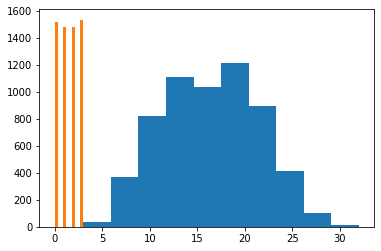

1.3322676295501878e-15
[0.007075 0.404875 1.180675 2.407375]
4
80
40
20
10


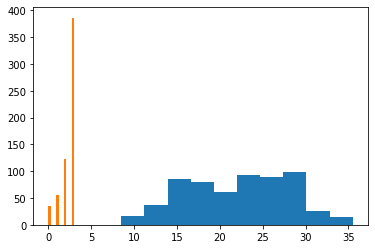

-85.14825488275494
[-11.45982537 -10.63827537  -6.69372537   7.24734963]
6
270
135
68
34
17
9


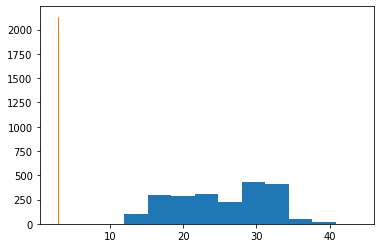

-298.68299271671947
[-31.3720309  -30.5504809  -26.6059309    7.24736769]
6
480
240
120
60
30
15


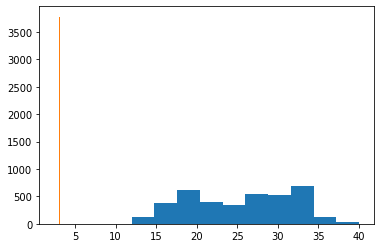

-303.34999999999974
[-46.5395309  -45.7179809  -41.7734309    7.24736769]


In [67]:
#Das ist unser Code
theta = theta_0
print(theta)
for n in range(1,5): # 5 frei gewählt, um schnelle Resultate zu sehen
    #print(n)
    eps_n = eps_0 * 1/(n**rho)
    sigma_n = 1/(n**r) * sigma_0
    gamma_n = gamma_0 * 1/n
    m_n = 2*max(math.ceil((np.log(1/eps_n)) / np.log(M)), 1)
    print(m_n)
    L_m = np.zeros(4)
    total_acts = list()
    for k in range(1,m_n+1):
        #N_nk = 100* math.ceil((1/np.sqrt(sigma_n))**2 * m_n * M**(-k))
        if n ==1: 
            N_nk = math.ceil(1000* (1/np.sqrt(sigma_n))**2 * m_n * M**(-k))
        else: 
            N_nk = math.ceil(10*(1/np.sqrt(sigma_n))**2 * m_n * M**(-k))
        print(N_nk)
        L_k = np.zeros(4)
        for l in range(1,N_nk+1):
            traject = sample(theta,t=0, state=0, action=None)
            acts = list()
            Q_k = list()
            Q_k2 = list()
            for t in range(time-1):
                state = traject[2*t]
                action = traject[2*t+1]
                acts.append(action)
                rew_to_go = 0
                for u in range(M**k):
                    t_to_go = sample(theta, t, state=state, action=action)
                    rew = np.array(t_to_go).reshape(int((len(t_to_go))/2),2)
                    for tup in rew[0:]:
                        rew_to_go += rewards[tup[0],tup[1]]
                if k ==1:
                    Q_k.append(1/(M**k) * rew_to_go)   
                    Q_k2.append(0)
                else: 
                    rew_to_go2 = 0
                    for u in range(M**(k-1)):
                        t_to_go = sample(theta, t, state=state, action=action)
                        rew = np.array(t_to_go).reshape(int((len(t_to_go))/2),2)
                        for tup in rew[0:]:
                            print(f"Reward: {rewards[tup[0],tup[1]]}")
                            rew_to_go2 += rewards[tup[0],tup[1]]
                    Q_k.append(1/(M**k) * rew_to_go)
                    Q_k2.append(1/(M**(k-1)) * rew_to_go2)
            total_acts.append(acts)  
            L_k = L_k +  np.sum(np.multiply(grad_soft(theta)[acts],(np.array(Q_k)-np.array(Q_k2))[:,np.newaxis]), axis=0)
        L_m = L_m +((1/N_nk) * L_k)
    plt.hist(np.array(total_acts).reshape(np.product(np.shape(total_acts))))
    plt.show()
    print(np.sum(L_m))
    theta = theta + gamma_n * L_m
    print(theta)

[1. 1. 1. 1.]
1


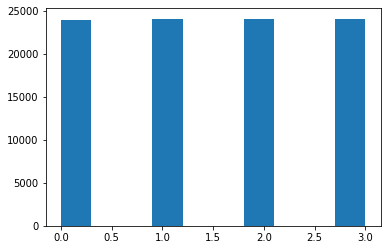

2.708944180085382e-14
[-0.27915   0.62595   1.449675  2.203525]
2


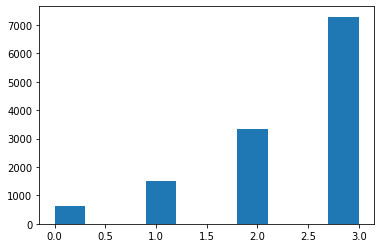

-61.66597403057005
[-10.58084805  -7.8297168   -2.98646055   6.8972332 ]
3


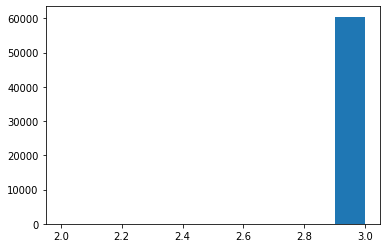

-322.988434907524
[-32.11399996 -29.36286871 -24.51895108   6.89834055]
4


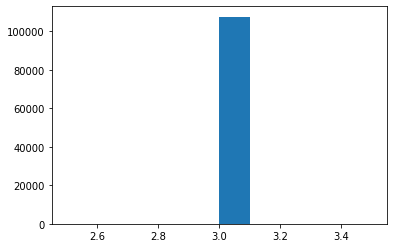

-323.5089285714465
[-48.28944638 -45.53831513 -40.69439751   6.89834055]


In [63]:
# Das ist der Standard Code ohne Multilevel
theta = theta_0
print(theta)
for n in range(1,5):
    print(n)
    eps_n = eps_0 * 1/(n**rho)
    sigma_n = 1/(n**r) * sigma_0
    gamma_n = gamma_0 * 1/n
    m_n = 2*max(math.ceil((np.log(1/eps_n)) / np.log(M)), 1)
    L_m = np.zeros(4)
    total_acts = list()
    if n==1:
        J = math.ceil(m_n * (1/np.sqrt(sigma_n))**2 * ((time-1)) * (m_n+1) * 1000)
    else:
        J = math.ceil(m_n * (1/np.sqrt(sigma_n))**2 * ((time-1)) * (m_n+1) * 10)
    for k in range(1,J):
        traject = sample(theta,t=0, state=0, action=None)
        acts = list()
        for t in range(time-1):
                state = traject[2*t]
                action = traject[2*t+1]
                acts.append(action)
        rew = np.array(traject[:-1]).reshape(int((len(traject[:-1]))/2),2)
        reward = 0
        for tup in rew[0:]:
                reward += rewards[tup[0],tup[1]]
        L_m = L_m +  (1/J) * np.sum((grad_soft(theta)[acts])*np.sum(reward), axis=0)
        total_acts.append(acts)
    
    plt.hist(np.array(total_acts).reshape(np.product(np.shape(total_acts))))
    plt.show()
    print(np.sum(L_m))    
    theta = theta + gamma_n * L_m
    print(theta)

In [59]:
theta = theta_0
print(theta)
for n in range(1,100):
    print(n)
    eps_n = eps_0 * 1/(n**rho)
    sigma_n = 1/(n**r) * sigma_0
    gamma_n = gamma_0 * 1/n
    m_n = max(math.ceil((np.log(1/eps_n)) / np.log(M)), 1)
    #print(m_n)
    L_m = np.zeros(4)
    J = math.ceil(100* m_n * (1/(sigma_n)) * (time*(time-1)))
    for k in range(1,J):
        traject = sample(theta,t=0, state=0, action=None)
        acts = list()
        for t in range(time-1):
                state = traject[2*t]
                action = traject[2*t+1]
                acts.append(action)
        rew = np.array(traject[:-1]).reshape(int((len(traject[:-1]))/2),2)
        reward = 0
        for tup in rew[0:]:
                reward += rewards[tup[0],tup[1]]
        L_m = L_m +  (1/J) * np.sum((grad_soft(theta)[acts])*np.sum(reward), axis=0)
    
    print(np.sum(L_m))    
    theta = theta + gamma_n * L_m
    print(theta)

[1. 1. 1. 1.]
1
1.3322676295501878e-15
[-0.2348  0.8284  1.3426  2.0638]
2
-48.923249326635926
[-9.36458745 -5.7016437  -2.2231062   6.61236255]
3


KeyboardInterrupt: 